<a href="https://colab.research.google.com/github/Ovizero01/Machine-Leaning/blob/main/026_Applied%20Machine%20Learning%20Foundations%2C%20Dataset%2C%20Eda%20%26%20First%20Model/026_laptop%20price%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv('laptop_price_prediction.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,brand,name,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,0,0,HP,Victus 15-fb0157AX Gaming Laptop,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920.0,1080.0,Windows 11 OS,1
1,1,1,HP,15s-fq5007TU Laptop,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920.0,1080.0,Windows 11 OS,1
2,2,2,Acer,One 14 Z8-415 Laptop,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920.0,1080.0,Windows 11 OS,1
3,3,3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240.0,1400.0,Windows 11 OS,1
4,4,4,Apple,MacBook Air 2020 MGND3HN Laptop,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560.0,1600.0,Mac OS,1


# Y Data Profiling


In [32]:
!pip install ydata-profiling

In [33]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Laptop Price Prediction", explorative=True)
profile.to_file("ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 36.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Drop data

In [34]:
df = df.iloc[:, 1:]
df = df.drop(df.columns[:1], axis=1)

In [35]:
df.head()

,brand,name,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,HP,Victus 15-fb0157AX Gaming Laptop,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920.0,1080.0,Windows 11 OS,1
1,HP,15s-fq5007TU Laptop,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920.0,1080.0,Windows 11 OS,1
2,Acer,One 14 Z8-415 Laptop,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920.0,1080.0,Windows 11 OS,1
3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240.0,1400.0,Windows 11 OS,1
4,Apple,MacBook Air 2020 MGND3HN Laptop,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560.0,1600.0,Mac OS,1


# Simplifying Columns

In [36]:
df.columns = [
    'brand', 'name', 'price', 'spec_rating', 'processor', 'CPU',
    'Ram', 'Ram_type', 'ROM', 'ROM_type', 'GPU', 'display_size',
    'resolution_width', 'resolution_height', 'OS', 'warranty'
]

# Correlation for Numerical Value

In [37]:
corr_target = df.select_dtypes(include=np.number).corr()['price'].sort_values(ascending=False)
print(corr_target)

price                1.000000
resolution_height    0.604748
resolution_width     0.586042
spec_rating          0.546391
display_size         0.233815
warranty             0.117101
Name: price, dtype: float64


# Separate X and y

In [38]:
X = df.drop('price', axis=1)
y = df['price']

# Numerical Column and Categorical Columns

In [39]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [40]:
numerical_features

Index(['spec_rating', 'display_size', 'resolution_width', 'resolution_height',
       'warranty'],
      dtype='object')

In [41]:
categorical_features

Index(['brand', 'name', 'processor', 'CPU', 'Ram', 'Ram_type', 'ROM',
       'ROM_type', 'GPU', 'OS'],
      dtype='object')

# Pipleline

In [42]:
# for numeric features
num_transformer = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

In [43]:
# for categorical features
cat_transformer = Pipeline(
    steps = [
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [44]:
# combine them
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

# Train-Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [46]:
#base learner
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
reg_xgb = XGBRegressor(n_estimators=100, random_state=42)

In [47]:
#voting regressor
voting_reg = VotingRegressor(
    estimators=[
        ('lr', reg_lr),
        ('rf', reg_rf),
        ('gb', reg_gb),
        ('xgb', reg_xgb)
    ]
)

In [48]:
#stacking
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator=Ridge()
)

# Model Training

In [49]:
model_to_train = {
    'Linear Regression': reg_lr,
    'Random Forest': reg_rf,
    'Gradient Boosting': reg_gb,
    'XGBRegressor': reg_xgb,
    'Voting Ensemble': voting_reg,
    'Stacking Ensemble': stacking_reg
}

In [64]:
# Training & Evaluation

result = []

for name, model in model_to_train.items():
  pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', model)
  ])

  # train
  pipe.fit(X_train, y_train)

  #predict
  y_pred = pipe.predict(X_test)

  #Evaluate
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  result.append({
      "Model": name,
      "R2 Score": r2,
      "RMSE": rmse,
      "MAE": mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)
print(results_df)

               Model  R2 Score          RMSE           MAE
4    Voting Ensemble  0.859173  21967.305545  12430.560453
3       XGBRegressor  0.855500  22251.980946  13064.837891
0  Linear Regression  0.854830  22303.511962  14177.329372
5  Stacking Ensemble  0.820246  24818.415693  13955.990326
1      Random Forest  0.816059  25105.764002  13331.777786
2  Gradient Boosting  0.799259  26227.246911  15236.329036


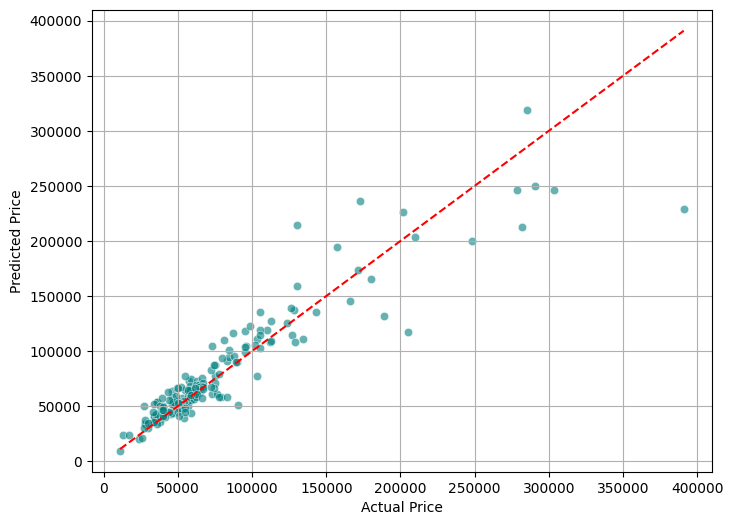

In [68]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

#fit the best model
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

final_pipe.fit(X_train,y_train)
y_final_pred = final_pipe.predict(X_test)


#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_final_pred, alpha = 0.6, color='teal' )
plt.plot( [min_val,max_val] , [min_val,max_val], color = "red", linestyle = '--'  )

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

plt.grid(True)
plt.show()